## 5. Series Temporales (Optativo)

In [40]:
import warnings
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math


import statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing

from pandas.plotting import lag_plot

import pyarrow
import fastparquet


In [4]:
df = pd.read_parquet('cupones_no_supervisado.parquet')

In [5]:
print(statsmodels.__version__)
warnings.filterwarnings('ignore')
%matplotlib inline

0.12.2


In [6]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(15, 10)})

Eliminamos outliers tal como se hace en el practico 2

In [19]:
df = df[df['fecha_cupon_movimiento'] > pd.to_datetime('2020-07-01')]
df = df[(df['monto_ajustado'] > -63712) & (df['monto_ajustado'] < 63712)]
df[['fecha_cupon_movimiento', 'monto_ajustado']]

,fecha_cupon_movimiento,monto_ajustado
0,2020-08-25,5.52
1,2020-08-25,15.68
2,2020-08-25,5.46
3,2020-08-25,2.50
4,2020-08-25,2.10
...,...,...
124309,2021-05-14,20329.24
124310,2021-05-14,20329.24
124311,2021-05-14,13210.67
124312,2021-05-03,121.73


In [41]:
# Agrupa por fecha todos los montos para Plan Largo
cols = ['fecha_cupon_movimiento', 'monto_ajustado']
sf = df[df['producto_naranja_movimiento'] == 'PL'][cols].groupby(by=['fecha_cupon_movimiento'], dropna=True).sum()

In [42]:
sf.reset_index(inplace=True)
sf

,fecha_cupon_movimiento,monto_ajustado
0,2020-07-05,-688.14
1,2020-07-06,-800.72
2,2020-07-07,-362.32
3,2020-07-14,-181.16
4,2020-07-20,4275.36
...,...,...
284,2021-04-30,-4766.28
285,2021-05-02,-77502.92
286,2021-05-06,9935.64
287,2021-05-10,259.38


In [43]:
print(sf['fecha_cupon_movimiento'].max())
print(sf['fecha_cupon_movimiento'].min())

2021-05-25 00:00:00
2020-07-05 00:00:00


In [44]:
sf.set_index('fecha_cupon_movimiento', inplace=True)
sf

,monto_ajustado
fecha_cupon_movimiento,
2020-07-05,-688.14
2020-07-06,-800.72
2020-07-07,-362.32
2020-07-14,-181.16
2020-07-20,4275.36
...,...
2021-04-30,-4766.28
2021-05-02,-77502.92
2021-05-06,9935.64


En series temporales se usa Series en lugar de Dataframe

In [45]:
ss = sf['monto_ajustado']
ss

fecha_cupon_movimiento
2020-07-05     -688.14
2020-07-06     -800.72
2020-07-07     -362.32
2020-07-14     -181.16
2020-07-20     4275.36
                ...   
2021-04-30    -4766.28
2021-05-02   -77502.92
2021-05-06     9935.64
2021-05-10      259.38
2021-05-25     6305.84
Name: monto_ajustado, Length: 289, dtype: float64

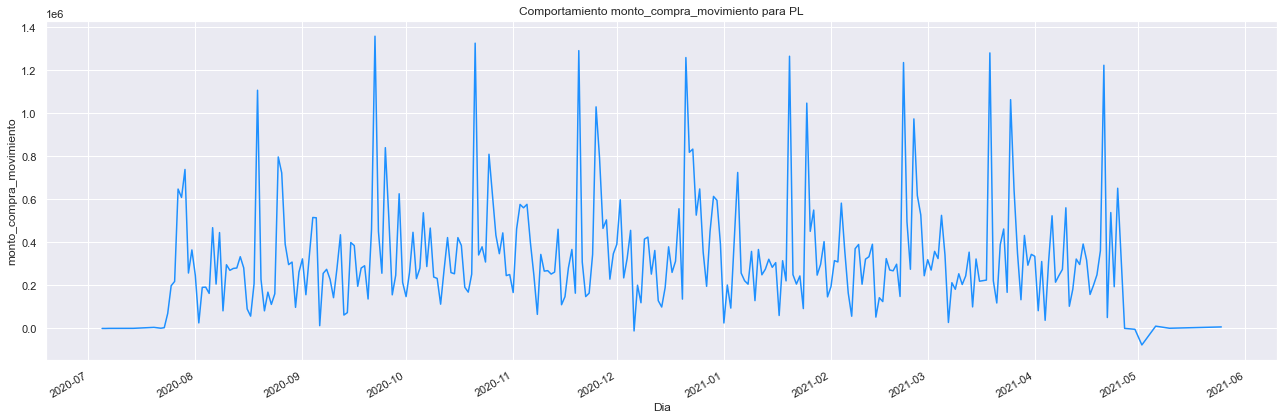

In [46]:
fig = plt.figure(figsize=(18, 6))

ax = plt.subplot(1, 1, 1)
ss.plot(color='dodgerblue')
ax.set_xlabel('Dia')
ax.set_ylabel('monto_compra_movimiento')
ax.set_title('Comportamiento monto_compra_movimiento para PL')

plt.tight_layout()
plt.show()

In [47]:
y_test = sf.monto_ajustado.loc['2021-03-19':]
y_train = sf[~sf.monto_ajustado.isin(y_test)].monto_ajustado


In [48]:
print(y_test.index.max())
print(y_test.index.min())

2021-05-25 00:00:00
2021-03-19 00:00:00


In [49]:
print(y_train.index.max())
print(y_train.index.min())

2021-03-18 00:00:00
2020-07-05 00:00:00


## Seasonal Random Walk (Seasonal Naïve)

#### Descomposicion

Una operación fundamental para entender el comportamiento de una serie de
 tiempo y poder determinar si se trata de una serie `estacionaria` o no

La **descomposición** es una técnica que trata de descomponer una serie de tiempo en su tendencia, su estacionalidad y sus factores residuales

Ejemplo de descomposición de serie de tiempo

<img 
src="https://i.imgur.com/g0PQASf.png" />


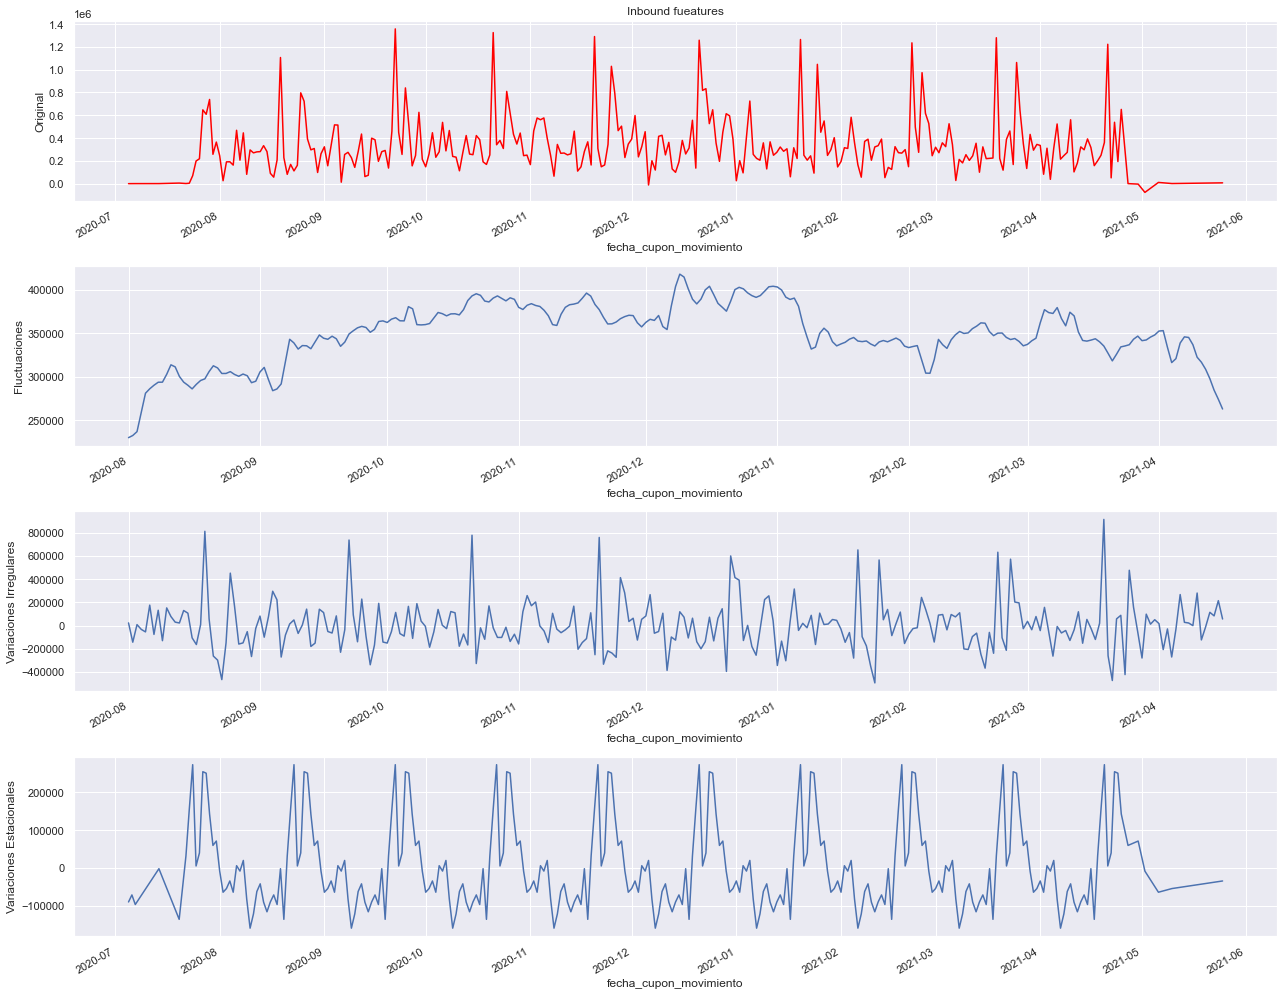

In [50]:
res = sm.tsa.seasonal_decompose(
    sf['monto_ajustado'], model='additive', freq=30
    )

fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(18, 14))

ax1.set_title('Inbound fueatures')
sf.monto_ajustado.plot(ax=ax1, color='red')
ax1.set_ylabel('Original')

res.trend.plot(ax=ax2)
ax2.set_ylabel('Fluctuaciones')

res.resid.plot(ax=ax3)
ax3.set_ylabel('Variaciones Irregulares')

res.seasonal.plot(ax=ax4)
ax4.set_ylabel('Variaciones Estacionales')
plt.tight_layout()
plt.show()

## Forecast

In [51]:
model = ARIMA(
    endog=y_train, exog=None, order=(0, 0, 1), seasonal_order=(0, 1, 0, 42) 
    ).fit()
    

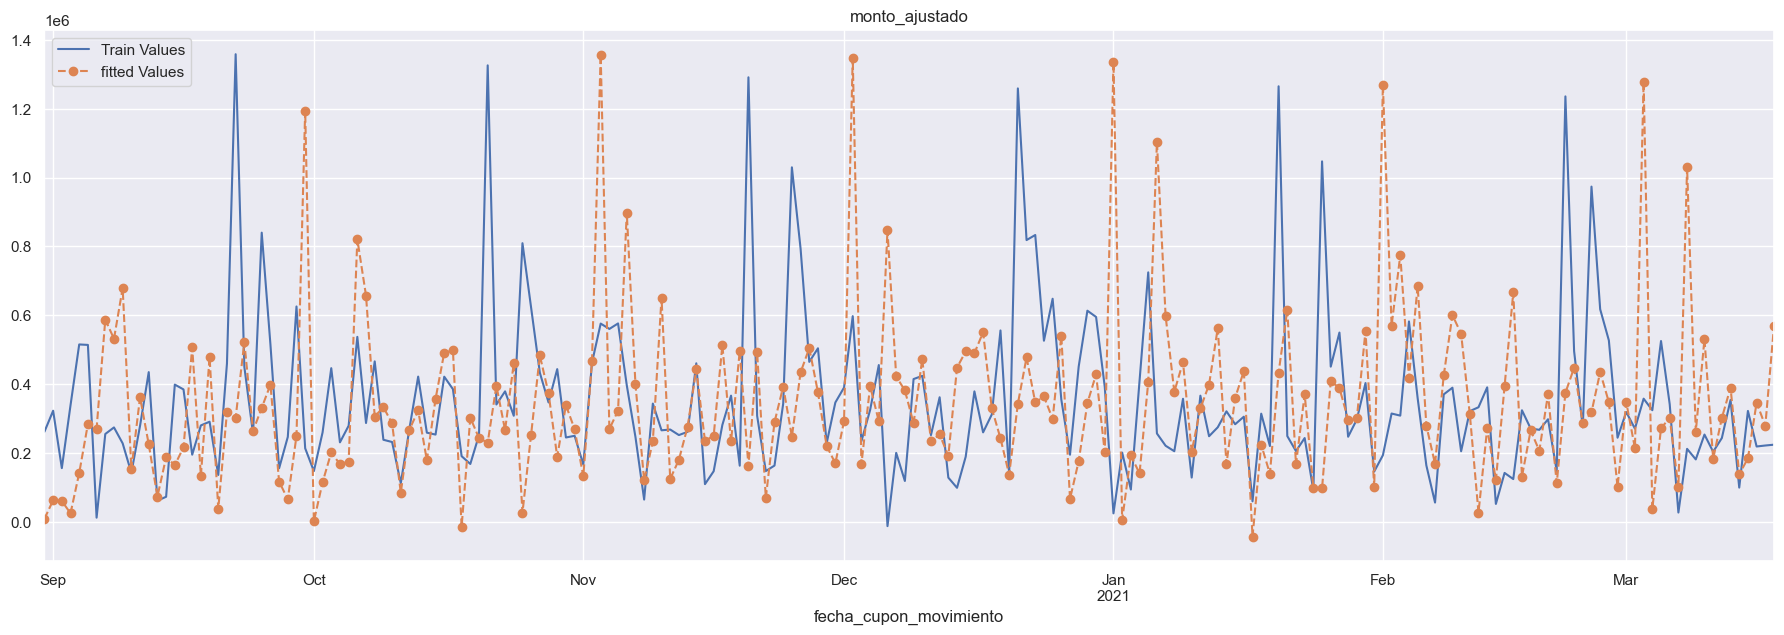

In [52]:
fig = plt.figure(figsize=(18, 12), dpi=100)

ax = plt.subplot(2, 1, 1)
y_train.tail(200).plot(ax=ax, label='Train Values', linestyle='-')
model.fittedvalues.tail(200).plot(
    ax=ax, label='fitted Values', marker='o', linestyle='--')
ax.set_title('monto_ajustado')
ax.legend()

plt.tight_layout()
plt.show()

In [53]:
# Forecast
# 95% conf se, conf
fc = model.forecast(steps=len(y_test), exog=y_test, alpha=0.05) 
#Make as pandas series
fc_in = fc.reset_index(drop=True)
fc_in.index = y_test.index

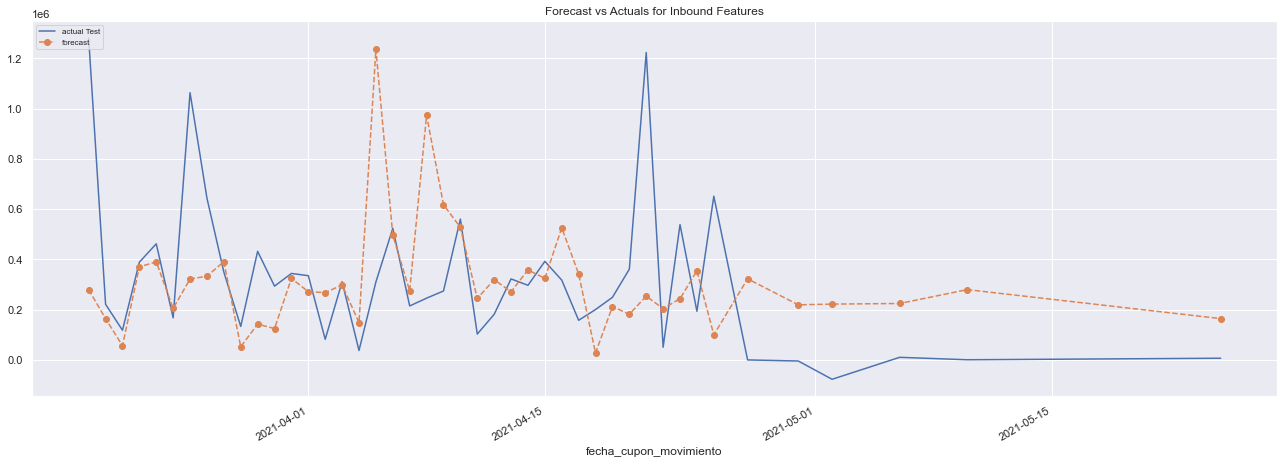

In [54]:
fig = plt.figure(figsize=(18, 12))

ax = plt.subplot(2, 1, 1)
y_test.plot(ax=ax, label='actual Test')
fc_in.plot(ax=ax, label='forecast', marker='o', linestyle='--')
ax.set_title('Forecast vs Actuals for Inbound Features')
ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

In [55]:
table = pd.DataFrame(
    [(sm.tools.eval_measures.rmse(y_test, fc_in), 
      (y_test - fc_in).sem())],
      columns=['RMSE','SE']
      )
table.round(3)

,RMSE,SE
0,347481.27,52979.854


## Exponential Smoothing

El método se suele usar cuando los datos no tienen patrones de tendencia ni estacional claros.




In [57]:
ss

fecha_cupon_movimiento
2020-07-05     -688.14
2020-07-06     -800.72
2020-07-07     -362.32
2020-07-14     -181.16
2020-07-20     4275.36
                ...   
2021-04-30    -4766.28
2021-05-02   -77502.92
2021-05-06     9935.64
2021-05-10      259.38
2021-05-25     6305.84
Name: monto_ajustado, Length: 289, dtype: float64

Text(0.5, 1.0, 'FIT 3, ALPHA automatico')

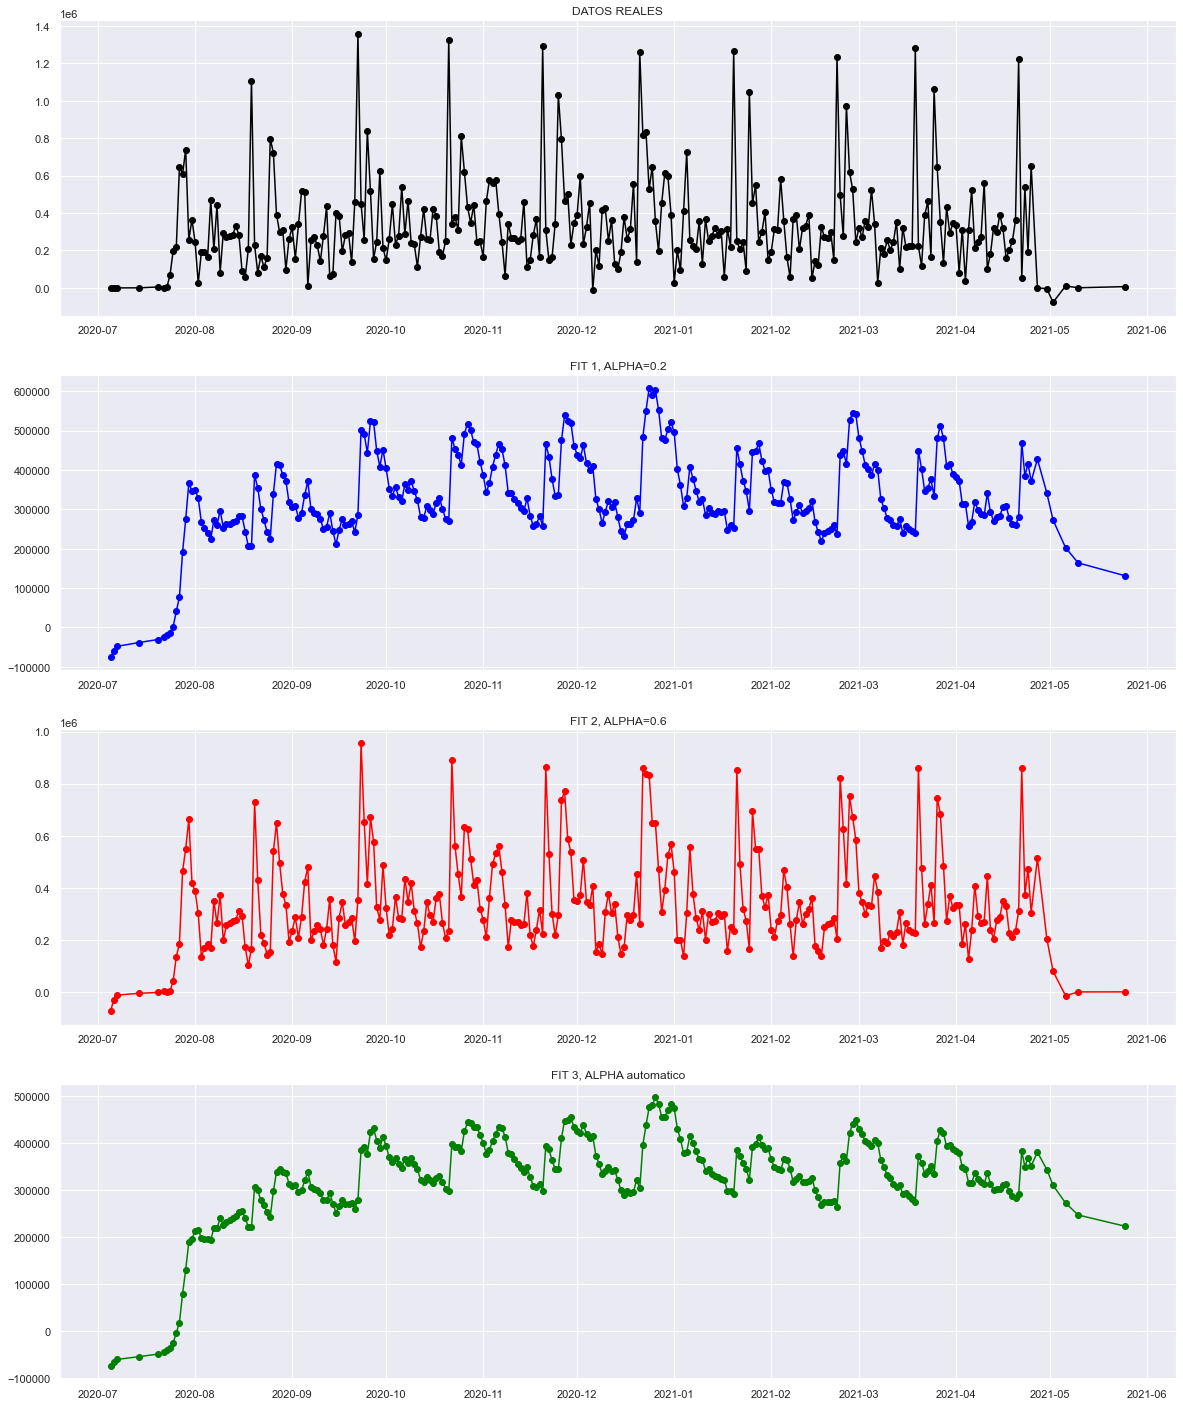

In [121]:
fit1 = SimpleExpSmoothing(ss, initialization_method="estimated").fit(
    smoothing_level=0.2, optimized=False
)
fcast1 = fit1.forecast().rename(r"$\alpha=0.2$")
fit2 = SimpleExpSmoothing(ss, initialization_method="estimated").fit(
    smoothing_level=0.6, optimized=False
)
fcast2 = fit2.forecast().rename(r"$\alpha=0.6$")
fit3 = SimpleExpSmoothing(ss, initialization_method="estimated").fit()
fcast3 = fit3.forecast().rename(r"$\alpha=%s$" % fit3.model.params["smoothing_level"])

fig, axes = plt.subplots(4,figsize=(20, 25))
axes[0].plot(ss, marker="o", color="black")
axes[0].set_title("DATOS REALES")
axes[1].plot(fit1.fittedvalues, marker="o", color="blue")
axes[1].set_title("FIT 1, ALPHA=0.2")
axes[2].plot(fit2.fittedvalues, marker="o", color="red")
axes[2].set_title("FIT 2, ALPHA=0.6")
axes[3].plot(fit3.fittedvalues, marker="o", color="green")
axes[3].set_title("FIT 3, ALPHA automatico")

Los puntos que se observan en cada grafico son los valores ajustados por la funcion SimpleExpSmoothing. Para cada uno de estos fit, se calculo un promedio que es el valor con el que se va a predecir algun valor futuro. Siempre se usaria el mismo valor, por lo que no tendria sentido usarlo para predecir nuestro conjunto de test, que ya sabemos que no se mantiene en un valor unico. Sin embargo, nos sirve ver que valor de alpha se ajusta mejor a los datos, que por lo que podemos observar es 0.6.

In [142]:
y_test = sf.monto_ajustado.loc['2021-03-19':]
y_train = sf[~sf.monto_ajustado.isin(y_test)].monto_ajustado


In [143]:
print(y_test.index.max())
print(y_test.index.min())

2021-05-25 00:00:00
2021-03-19 00:00:00


In [144]:
print(y_train.index.max())
print(y_train.index.min())

2021-03-18 00:00:00
2020-07-05 00:00:00


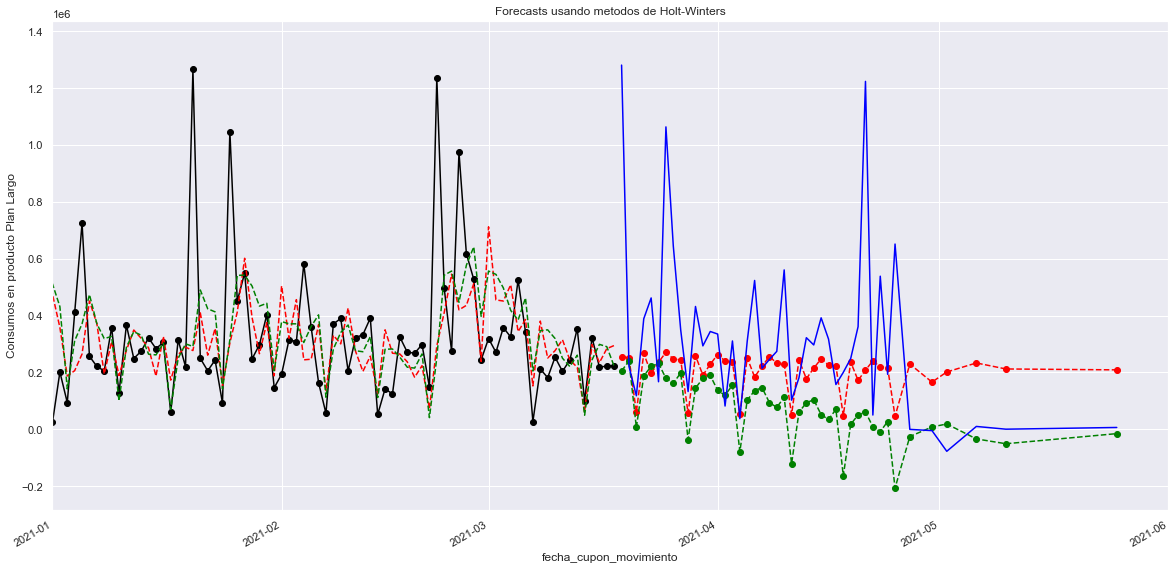

Figura que muestra el consumo de clientes en el producto PL usando el metodo Holt-Winters     con estacionalidad multiplicada y sumada. 


In [165]:
fit1 = ExponentialSmoothing(
    y_train[y_train > 0],
    seasonal_periods=7,
    trend="additive",
    seasonal="additive",
    use_boxcox=True,
    initialization_method="heuristic",
    bounds={'smoothing_level':(0.2, 0.6)}
).fit()
fit2 = ExponentialSmoothing(
    y_train,
    seasonal_periods=7,
    trend="additive",
    seasonal="additive",
    use_boxcox=False,
    initialization_method="estimated",
    bounds={'smoothing_level':(0.2, 0.6)}
).fit()
results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)
params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]
results["Additive"] = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]

ax = y_train.plot(
    figsize=(20, 10),
    marker="o",
    color="black",
    title="Forecasts usando metodos de Holt-Winters",
)
ax.set_ylabel("Consumos en producto Plan Largo")
ax.set_xlabel("Fecha")
fit1.fittedvalues.plot(ax=ax, style="--", color="red")
fit2.fittedvalues.plot(ax=ax, style="--", color="green")

# Forecast

fc1 = fit1.forecast(len(y_test)) 
fc_in1 = fc1.reset_index(drop=True)
fc_in1.index = y_test.index

fc2 = fit2.forecast(len(y_test)) 
fc_in2 = fc2.reset_index(drop=True)
fc_in2.index = y_test.index

fc_in1.plot(ax=ax, style="--", marker="o", color="red")
fc_in2.plot(ax=ax, style="--", marker="o", color="green")


y_test.plot(ax=ax, color='blue')

ax.set_xlim(pd.Timestamp('2021-01-01'), pd.Timestamp('2021-06-01'))

plt.show()
print(
    "Figura que muestra el consumo de clientes en el producto PL usando el metodo Holt-Winters \
    con estacionalidad multiplicada y sumada. "
)

In [154]:
results

,Additive,Multiplicative
$\alpha$,1.817857e-01,2.525000e-01
$\beta$,3.029762e-02,5.410714e-02
$\phi$,NaN,NaN
$\gamma$,1.258791e-01,1.000000e-04
$l_0$,2.876675e+02,-1.050168e+05
$b_0$,1.027990e+00,5.821848e+04
SSE,1.570636e+13,1.435628e+13
